In [6]:
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import gc
import json

import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc
import os
import sys
sys.path.append('..')

from src import metric_fast
import joblib
import time
import importlib
importlib.reload(metric_fast)

<module 'src.metric_fast' from '/home/sleep-kaggle/kaggle_submit_solution/nbs/../src/metric_fast.py'>

In [30]:
# pip freeze > ../requirements.txt

In [7]:
class cfg:
    samp_freq=1
    gaussian_overlay_len = 60
    std_dev_num = 2400
    ver='fm-v13-final'

In [8]:
settings_json = json.load(open('../settings.json', 'r'))
print(settings_json)

for k,v in settings_json.items():
    setattr(cfg, k, v)
    
print(cfg.__dict__)

{'train_events_path': '../data/train_events.csv', 'train_series_path': '../data/train_series.parquet', 'processed_data_path': '../data_processed_models', 'models_path': '../outputs'}
{'__module__': '__main__', 'samp_freq': 1, 'gaussian_overlay_len': 60, 'std_dev_num': 2400, 'output_dir': '../outputs', 'ver': 'fm-v13-final', '__dict__': <attribute '__dict__' of 'cfg' objects>, '__weakref__': <attribute '__weakref__' of 'cfg' objects>, '__doc__': None, 'train_events_path': '../data/train_events.csv', 'train_series_path': '../data/train_series.parquet', 'processed_data_path': '../data_processed_models', 'models_path': '../outputs'}


In [9]:
%%time
train_events = pl.read_ipc(os.path.join(cfg.processed_data_path, 'train_events.ipc'))

CPU times: user 0 ns, sys: 3.3 ms, total: 3.3 ms
Wall time: 3.28 ms


Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


In [11]:
splits_df = train_events[['series_id']].unique(maintain_order=True)
splits_df = splits_df.to_pandas()

for n_splits in [5, 7, 10]:
    folds = KFold(n_splits, shuffle=True, random_state=5)

    splits_df[f'{n_splits}_fold'] = 0
    for i, (trn_idx, val_idx) in enumerate(folds.split(splits_df['series_id'], splits_df['series_id'])):
        
        splits_df.loc[val_idx, f'{n_splits}_fold'] = i+1
        
        
splits_df = pl.DataFrame(splits_df)

In [12]:
splits_df

series_id,5_fold,7_fold,10_fold
str,i64,i64,i64
"""038441c925bb""",5,6,9
"""03d92c9f6f8a""",2,3,4
"""0402a003dae9""",5,6,9
"""04f547b8017d""",1,1,2
"""05e1944c3818""",3,4,6
"""062cae666e2a""",5,6,9
"""062dbd4c95e6""",1,1,2
"""08db4255286f""",5,7,10
"""0a96f4993bd7""",5,7,10


In [13]:
def load_data(directory):
    X_s = []
    y_s = []
    series_ids = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('_X.npy'):
            series_id = filename.split('_X.npy')[0]
            X = np.load(os.path.join(directory, filename))
            y = np.load(os.path.join(directory, f'{series_id}_y.npy'))

            X_s.append(X)
            y_s.append(y)
            series_ids.append(series_id)

    return X_s, y_s, series_ids

In [14]:
def normalize_y(y):
    
    for i in range(y.shape[1]):
        
        mean = y[:,i].mean()
        std = y[:,i].std()
        y[:,i] = (y[:,i]-mean)/(std+1e-16)
    
    return y

In [15]:
def split_and_pad(X, y=None, split_length=1440, stride=1440):
    """
    Splits and pads the arrays X and y using a sliding window.

    Parameters:
    - X (np.array): Array with shape (timesteps, features)
    - y (np.array): Array with shape (timesteps, 2)
    - split_length (int): Desired timestep length for the resulting arrays.
    - stride (int): Step size for sliding window.

    Returns:
    - List of arrays for X and y, each with shape (split_length, features)
    """
    
    if y is not None and len(X) != len(y):
        raise ValueError("X and y should have the same number of timesteps.")
    
    timesteps, features = X.shape
    
    # Create empty lists to store split segments
    X_splits = []
    y_splits = []
    starts = []
    
    # Use sliding window to extract segments
    
    for start in range(0, timesteps, stride):
        end = start + split_length
        if end <= timesteps:
            starts.append(start)
            X_splits.append(X[start:end].copy())
            if y is not None:
                y_splits.append(y[start:end].copy())
        else:
            # If the segment is shorter than split_length, pad it
            starts.append(start)
            padding_length = end - timesteps
            X_segment_padded = np.pad(X[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=-9)
            X_splits.append(X_segment_padded)
            
            if y is not None:
                y_segment_padded = np.pad(y[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                y_splits.append(y_segment_padded)
                
            break
            
            
    if y is not None:
        return X_splits, y_splits, starts
    
    return X_splits, starts



class SleepDataset:
    
    def __init__(self, X_s, y_s=None, series_ids=None, samp_freq=None, remove_no_dets=True, is_train=False, split_factor=1, norm_params=None):
        
        self.split_len = (24*60*12) // cfg.samp_freq
        self.split_strides = self.split_len
        self.remove_no_dets = remove_no_dets
        self.is_train = is_train

        print(f'Using a split len of {self.split_len}')
        self.create_dataset(X_s, y_s, series_ids)

        if self.is_train:
            self.norm_params = self.calculate_norm_params()
        else:
            if norm_params is None:
                raise ValueError("Normalization parameters must be provided for non-training data.")
            self.norm_params = norm_params

        self.normalize_data()

    def calculate_norm_params(self):
        mean = np.mean(self.X, axis=(0, 1))
        std = np.std(self.X, axis=(0, 1))
        return {'mean': mean, 'std': std}

    def normalize_data(self):
        self.X = (self.X - self.norm_params['mean']) / (1e-6 + self.norm_params['std'])
        
        
    def create_dataset(self, X_s, y_s=None, series_ids=None):
        X_s_splits, y_s_splits, series_splits, starts_splits = [], [], [], []

        for i in tqdm(range(len(X_s))):
            x_splits, starts = split_and_pad(X_s[i].copy(), split_length = self.split_len, stride=self.split_strides)
            X_s_splits.extend(x_splits)
            starts_splits.extend(starts)

            if y_s is not None:
                _, y_splits, _ = split_and_pad(X_s[i].copy(), y_s[i].copy(), split_length=self.split_len, stride=self.split_strides)
                y_s_splits.extend(y_splits)

            if series_ids is not None:
                series_splits.extend([series_ids[i] for _ in range(len(x_splits))])
            
        self.X = np.array(X_s_splits)
        self.starts_splits = np.array(starts_splits)
        
        if y_s is not None:
            self.y = np.array(y_s_splits)

            if self.remove_no_dets:
                fltr = (self.y[:, :, 1].sum(axis=1) + self.y[:, :, 0].sum(axis=1)) != 0
                self.X = self.X[fltr]
                self.y = self.y[fltr]
                if series_ids is not None:
                    self.series_ids = np.array(series_splits)[fltr]
                else:
                    self.series_ids = None
            
            self.y = np.array([normalize_y(yts) for yts in self.y])

        else:
            self.y = None

        if series_ids is not None:
            if not hasattr(self, 'series_ids'):
                self.series_ids = np.array(series_splits)
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}, series_ids: {self.series_ids.shape}')
        else:
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}')

In [16]:
def nms_nikhil(preds_orig, k_orig=125, max_thresh=0.05, max_count=1000):
    
    preds=preds_orig.copy()

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]
        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)


def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [17]:
def calculate_exponential_lr(start_lr, end_lr, num_steps, decay_rate=None):
    """
    Calculate the exponentially decreasing learning rates.

    Parameters:
    start_lr (float): Initial learning rate.
    end_lr (float): Final learning rate.
    num_steps (int): Total number of steps over which the learning rate should decay.
    decay_rate (float): Decay rate per step. If None, it will be computed based on start_lr, end_lr, and num_steps.

    Returns:
    list: A list containing the learning rate for each step.
    """
    if decay_rate is None:
        # Calculate decay rate based on the start_lr, end_lr, and num_steps
        decay_rate = (end_lr / start_lr) ** (1 / (num_steps - 1))

    learning_rates = [start_lr * (decay_rate ** step) for step in range(num_steps)]
    return learning_rates



In [18]:
class IntervalEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, val_events_df, samp_freq, n_steps, start_lr, end_lr):

        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_ds = val_ds
        self.val_events_df = val_events_df
        self.samp_freq = samp_freq
        
        warmup_pct_steps = 0.25
        warmup_steps = int(n_steps * warmup_pct_steps)
        self.learning_rates = [start_lr] * (warmup_steps) + calculate_exponential_lr(start_lr, end_lr, n_steps-warmup_steps)
        self.best_score = -np.inf
        self.best_model = None
        self.step_count=0

    def on_epoch_begin(self, epoch, logs={}):

        self.start_time = time.time()
        
        if epoch == 0:
            self.first_epoch_start_time = self.start_time
        
    def on_train_batch_begin(self, batch, logs=None):
        if self.step_count < len(self.learning_rates):

            tf.keras.backend.set_value(self.model.optimizer.lr, self.learning_rates[self.step_count])
            self.curr_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.step_count += 1
    
    def on_epoch_end(self, epoch, logs={}):

        val_preds = self.model.predict(self.val_ds.X, batch_size=32, verbose=0)[:, :, :2]
        val_score = post_process_preds(self.val_events_df, val_preds, self.val_ds.series_ids, self.val_ds.starts_splits, self.samp_freq, get_score=True)
        
        if val_score > self.best_score:
            self.best_score = val_score
            self.best_model = tf.keras.models.clone_model(self.model)
            self.best_model.set_weights(self.model.get_weights()) 
        
        total_time = round(time.time() - self.start_time, 2)
        total_seconds_till_now = round(time.time() - self.first_epoch_start_time, 0)
        
        print(f"Epoch: {epoch:03d} curr_lr: {self.curr_lr:.1e} - train_loss: {logs['loss']:.04f} - val_loss: {logs['val_loss']:.04f} val_score: {val_score:.03f}  best_val_score: {self.best_score:.03f}  last_epoch t={total_time:.02f}s, total_time_elapsed t={total_seconds_till_now}s")
        

In [19]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # MultiHead Attention
    x = tfa.layers.MultiHeadAttention(
        head_size=head_size,
        num_heads=num_heads,
        use_projection_bias=True,
        dropout=dropout
    )([inputs, inputs, inputs])

    # Residual connection with LayerNormalization and Scaling
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs) * (0.5 ** 0.5)
    
    # Feed Forward Part
    ff = tf.keras.layers.Dense(ff_dim, activation='gelu')(x)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    
    # Residual connection with LayerNormalization and Scaling for FFN
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff) * (0.5 ** 0.5)

    return x

In [20]:
def custom_mce_loss(y_true, y_pred):
    # Clip the ground truth and predictions to the range (-100, 100)
    y_true_clipped = tf.clip_by_value(y_true, -100, 100)
    y_pred_clipped = tf.clip_by_value(y_pred, -100, 100)

    # Calculate the mean cubed error
    loss = tf.reduce_mean(tf.abs(y_true_clipped - y_pred_clipped) ** 3)
    return loss

In [21]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    return x, p

def decoder_block(inputs, concat_tensors, num_filters):
    x = tf.keras.layers.Conv1DTranspose(num_filters, 4, strides=2, padding="same")(inputs)
    i = len(concat_tensors)-1
    for concat_tensor in concat_tensors:
        concat_tensor_max = tf.keras.layers.MaxPool1D(pool_size=2**i)(concat_tensor)
        x = tf.keras.layers.Concatenate()([x, concat_tensor_max])
        i -= 1
        
    x = conv_block(x, num_filters)
    return x

def get_model(input_shape, num_blocks=4):
    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    
    orig_n_channels = x.shape[-1]
    
    x_t = []
    n_split_fact = 4
    
    
    for i in range(x.shape[-1]):
        x_sp = tf.reshape(x[:, :, i], (-1, x.shape[1]//n_split_fact, n_split_fact))
        
        if i < orig_n_channels:
        
            # Calculating mean, max, and standard deviation
            mean = tf.reduce_mean(x_sp, axis=-1, keepdims=True)
            max_val = tf.reduce_max(x_sp, axis=-1, keepdims=True)
            std_dev = tf.math.reduce_std(x_sp, axis=-1, keepdims=True)
            min_val = tf.reduce_min(x_sp, axis=-1, keepdims=True)

            x_sp = tf.keras.layers.Concatenate()([x_sp, mean, max_val, std_dev, min_val])
        
        x_sp = tf.keras.layers.Dense(n_split_fact*16, activation='relu')(x_sp)
        
        x_t.append(x_sp)
        
    
    x_c1d = tf.keras.layers.Conv1D(64, kernel_size=12, strides=n_split_fact, padding="same")(x)
    x_c1d = tf.keras.layers.ReLU()(x_c1d)

    x = tf.keras.layers.Concatenate()(x_t + [x_c1d])# tf.reshape(x, (-1, -1, 3))
    
    # Initial filter size
    fsz = 64
    
    # Lists to hold the encoder and pooling outputs
    encoder_outputs = []
    pooling_outputs = []
    
    # Encoder
    for i in range(num_blocks):
        if i == 0:
            # First block receives the model input
            enc_out, pool_out = encoder_block(x, fsz * (2 ** i))
        else:
            # Subsequent blocks receive the pooling output of the previous block
            enc_out, pool_out = encoder_block(pooling_outputs[-1], fsz * (2 ** i))
        
        encoder_outputs.append(enc_out)
        pooling_outputs.append(pool_out)
    
    # Bottleneck
    bottleneck = conv_block(pooling_outputs[-1], fsz * (2 ** num_blocks))
    
    
    def gru_conv(x):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(x.shape[-1]//4, return_sequences=True))(x)
        for i in range(1):
            x_conv = tf.keras.layers.Conv1D(x.shape[-1], kernel_size=(4,), padding='same', activation='relu')(x)
            x = tf.keras.layers.Dense(x.shape[-1], activation='relu')(x_conv)

        return x
    
    for _ in range(1):
        bottleneck = transformer_encoder(bottleneck, head_size=16, num_heads=8, ff_dim=256, dropout=0)

    bottleneck = gru_conv(bottleneck)

    decoder_input = bottleneck
    for i in range(num_blocks - 1, -1, -1):
        decoder_output = decoder_block(decoder_input, encoder_outputs[:i+1], fsz * (2 ** i))
        decoder_input = decoder_output
    
    # Output Layer
    x = tf.keras.layers.Conv1D(2*n_split_fact, 1, padding="same", activation="linear")(decoder_output)
    x = tf.reshape(x, shape=(-1, x.shape[1]*n_split_fact, 2))
    
    outputs = x
    
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), loss=custom_mce_loss)
    
    return model

# Usage:
input_shape = (17280, 9)  # replace with your input shape
num_blocks = 4  # specify the number of encoder/decoder blocks
model = get_model(input_shape, num_blocks)
model.count_params()

2023-12-15 09:11:23.299769: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 09:11:23.506315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46413 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:23:00.0, compute capability: 8.9
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than onc

33813832

In [22]:
class model_cfg:
    n_epochs = 14
    batch_size = 8
    start_lr = 6e-5
    end_lr = 2e-5

In [23]:
_ = gc.collect()

In [24]:
cfg.processed_data_path

'../data_processed_models'

In [25]:
n_folds = 5
fold_run_order = [2, 1, 3, 4, 5]

val_preds_lst = []
val_series_lst = []
val_starts_splits_lst = []

val_y_lst = []
models_lst = []
val_scores = []

model_dct = {}

for fold_num in fold_run_order:
    
    X_s, y_s, series_ids = load_data(cfg.processed_data_path)
    

    print(f'\n\n\n-----------Starting fold: {fold_num}-----------\n\n\n')
    
    series_ids_val = splits_df.filter(pl.col(f'{n_folds}_fold') == fold_num)['series_id'].to_numpy()

    val_idxs = [series_ids.index(s) for s in series_ids_val]
    trn_idxs = np.setdiff1d(np.arange(len(series_ids)), val_idxs)
    
    print(f'Using {len(trn_idxs)} series for training and {len(val_idxs)} series for validation')

    X_s_trn, y_s_trn, series_ids_trn = [X_s[i] for i in trn_idxs], [y_s[i] for i in trn_idxs], [series_ids[i] for i in trn_idxs]
    X_s_val, y_s_val, series_ids_val = [X_s[i] for i in val_idxs], [y_s[i] for i in val_idxs], [series_ids[i] for i in val_idxs]

    trn_ds = SleepDataset(X_s_trn, y_s_trn, series_ids_trn, cfg.samp_freq, remove_no_dets=False, is_train=True)
    norm_params = trn_ds.norm_params
    model_dct[fold_num] = norm_params
    
    val_ds = SleepDataset(X_s_val, y_s_val, series_ids_val, cfg.samp_freq, remove_no_dets=False, is_train=False, norm_params=norm_params)

    del X_s_trn, y_s_trn,  X_s_val, y_s_val, series_ids_trn, X_s, y_s, series_ids
    _ = gc.collect()


    model = get_model(trn_ds.X.shape[1:])
    
    print(f'Total model parameters: {model.count_params()}')

    val_events_df = train_events.filter(pl.col('series_id').is_in(series_ids_val))
    inter_eval = IntervalEvaluation(val_ds, val_events_df, cfg.samp_freq, (trn_ds.X.shape[0]//model_cfg.batch_size)*model_cfg.n_epochs, model_cfg.start_lr, model_cfg.end_lr)
    
    model.fit(trn_ds.X, trn_ds.y,
          epochs=model_cfg.n_epochs,
          batch_size=model_cfg.batch_size,
          callbacks=[inter_eval],
          verbose=1,
          validation_data=(val_ds.X, val_ds.y))
    
    
    
    last_loss = model.history.history['val_loss'][-1]
    print(f'Model finished with val loss: {last_loss}')
    
    model = inter_eval.best_model
    val_preds = model.predict(val_ds.X)
    
    val_score = post_process_preds(val_events_df, val_preds, val_ds.series_ids, val_ds.starts_splits, cfg.samp_freq, get_score=True)
    print(f'Val Score: {val_score}')
    
    val_scores.append(val_score)
    
    val_y_lst.append(val_ds.y)
    val_preds_lst.append(val_preds)
    val_series_lst.append(val_ds.series_ids)
    val_starts_splits_lst.append(val_ds.starts_splits)
    
    tf.keras.models.save_model(model, os.path.join(cfg.output_dir, cfg.ver, f'tf_model_fold_{fold_num}.h5'))
    
    del trn_ds, val_ds, model, inter_eval
    _ = gc.collect()

avg_val_score, std_val_score = np.mean(val_scores), np.std(val_scores)
print(f'Avg val score: {avg_val_score} and std val score: {std_val_score}')

100%|██████████| 529/529 [00:04<00:00, 119.38it/s]





-----------Starting fold: 2-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:12<00:00, 16.99it/s]


X: (5742, 17280, 32), y: (5742, 17280, 2), series_ids: (5742,)
Using a split len of 17280


100%|██████████| 53/53 [00:00<00:00, 68.46it/s]


X: (1462, 17280, 32), y: (1462, 17280, 2), series_ids: (1462,)


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Total model parameters: 34598408
Epoch 1/14


2023-12-15 09:13:57.027467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-12-15 09:13:57.041566: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


718/718 [==============================] - 82s 104ms/step - loss: 4.5810 - val_loss: 3.7517
Epoch 2/14
718/718 [==============================] - 67s 93ms/step - loss: 3.7207 - val_loss: 4.0584
Epoch 3/14
718/718 [==============================] - 70s 97ms/step - loss: 3.6052 - val_loss: 3.4685
Epoch 4/14
718/718 [==============================] - 69s 96ms/step - loss: 3.5499 - val_loss: 3.4015
Epoch 5/14
718/718 [==============================] - 68s 95ms/step - loss: 3.4894 - val_loss: 3.3430
Epoch 6/14
718/718 [==============================] - 68s 95ms/step - loss: 3.4551 - val_loss: 3.3017
Epoch 7/14
718/718 [==============================] - 67s 94ms/step - loss: 3.4252 - val_loss: 3.3627
Epoch 8/14
718/718 [==============================] - 66s 92ms/step - loss: 3.3963 - val_loss: 3.2926
Epoch 9/14
718/718 [==============================] - 66s 91ms/step - loss: 3.3692 - val_loss: 3.3679
Epoch 10/14
718/718 [==============================] - 66s 92ms/step - loss: 3.3440 - val_lo

2023-12-15 09:28:29.472247: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


UnknownError: Graph execution error:

Detected at node 'model_1/conv1d_22/Conv1D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5043/2478982756.py", line 48, in <module>
      model.fit(trn_ds.X, trn_ds.y,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1624, in fit
      callbacks.on_epoch_end(epoch, epoch_logs)
    File "/usr/local/lib/python3.8/dist-packages/keras/callbacks.py", line 448, in on_epoch_end
      callback.on_epoch_end(epoch, logs)
    File "/tmp/ipykernel_5043/2369401257.py", line 32, in on_epoch_end
      val_preds = self.model.predict(self.val_ds.X, batch_size=32, verbose=0)[:, :, :2]
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/conv1d_22/Conv1D'
CUDNN failed to allocate the scratch space for the runner or to find a working no-scratch runner.
	 [[{{node model_1/conv1d_22/Conv1D}}]] [Op:__inference_predict_function_33711]

In [17]:
n_folds = 5
fold_run_order = [2, 1, 3, 4, 5]

val_preds_lst = []
val_series_lst = []
val_starts_splits_lst = []

val_y_lst = []
models_lst = []
val_scores = []

model_dct = {}

for fold_num in fold_run_order:
    
    X_s, y_s, series_ids = load_data(cfg.processed_data_path)
    

    print(f'\n\n\n-----------Starting fold: {fold_num}-----------\n\n\n')
    
    series_ids_val = splits_df.filter(pl.col(f'{n_folds}_fold') == fold_num)['series_id'].to_numpy()

    val_idxs = [series_ids.index(s) for s in series_ids_val]
    trn_idxs = np.setdiff1d(np.arange(len(series_ids)), val_idxs)
    
    print(f'Using {len(trn_idxs)} series for training and {len(val_idxs)} series for validation')

    X_s_trn, y_s_trn, series_ids_trn = [X_s[i] for i in trn_idxs], [y_s[i] for i in trn_idxs], [series_ids[i] for i in trn_idxs]
    X_s_val, y_s_val, series_ids_val = [X_s[i] for i in val_idxs], [y_s[i] for i in val_idxs], [series_ids[i] for i in val_idxs]

    trn_ds = SleepDataset(X_s_trn, y_s_trn, series_ids_trn, cfg.samp_freq, remove_no_dets=False, is_train=True)
    norm_params = trn_ds.norm_params
    model_dct[fold_num] = norm_params
    
    val_ds = SleepDataset(X_s_val, y_s_val, series_ids_val, cfg.samp_freq, remove_no_dets=False, is_train=False, norm_params=norm_params)

    del X_s_trn, y_s_trn,  X_s_val, y_s_val, series_ids_trn, X_s, y_s, series_ids
    _ = gc.collect()


    model = get_model(trn_ds.X.shape[1:])
    
    print(f'Total model parameters: {model.count_params()}')

    val_events_df = train_events.filter(pl.col('series_id').is_in(series_ids_val))
    inter_eval = IntervalEvaluation(val_ds, val_events_df, cfg.samp_freq, (trn_ds.X.shape[0]//model_cfg.batch_size)*model_cfg.n_epochs, model_cfg.start_lr, model_cfg.end_lr)
    
    model.fit(trn_ds.X, trn_ds.y,
          epochs=model_cfg.n_epochs,
          batch_size=model_cfg.batch_size,
          callbacks=[inter_eval],
          verbose=1,
          validation_data=(val_ds.X, val_ds.y))
    
    
    
    last_loss = model.history.history['val_loss'][-1]
    print(f'Model finished with val loss: {last_loss}')
    
    model = inter_eval.best_model
    val_preds = model.predict(val_ds.X)
    
    val_score = post_process_preds(val_events_df, val_preds, val_ds.series_ids, val_ds.starts_splits, cfg.samp_freq, get_score=True)
    print(f'Val Score: {val_score}')
    
    val_scores.append(val_score)
    
    val_y_lst.append(val_ds.y)
    val_preds_lst.append(val_preds)
    val_series_lst.append(val_ds.series_ids)
    val_starts_splits_lst.append(val_ds.starts_splits)
    
    tf.keras.models.save_model(model, os.path.join(cfg.output_dir, cfg.ver, f'tf_model_fold_{fold_num}.h5'))
    
    del trn_ds, val_ds, model, inter_eval
    _ = gc.collect()

avg_val_score, std_val_score = np.mean(val_scores), np.std(val_scores)
print(f'Avg val score: {avg_val_score} and std val score: {std_val_score}')

100%|██████████| 529/529 [00:04<00:00, 129.76it/s]





-----------Starting fold: 2-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:11<00:00, 18.66it/s]


X: (5742, 17280, 32), y: (5742, 17280, 2), series_ids: (5742,)
Using a split len of 17280


100%|██████████| 53/53 [00:00<00:00, 69.57it/s]


X: (1462, 17280, 32), y: (1462, 17280, 2), series_ids: (1462,)
Total model parameters: 34598408
Epoch 1/14


2023-12-14 06:00:13.090553: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 06:00:13.122684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


718/718 [==============================] - 78s 99ms/step - loss: 4.4215 - val_loss: 3.7856
Epoch 2/14
718/718 [==============================] - 67s 93ms/step - loss: 3.7059 - val_loss: 3.5250
Epoch 3/14
718/718 [==============================] - 64s 89ms/step - loss: 3.5783 - val_loss: 3.4094
Epoch 4/14
718/718 [==============================] - 66s 92ms/step - loss: 3.5287 - val_loss: 3.4144
Epoch 5/14
718/718 [==============================] - 65s 90ms/step - loss: 3.4928 - val_loss: 3.3444
Epoch 6/14
718/718 [==============================] - 66s 92ms/step - loss: 3.4490 - val_loss: 3.3179
Epoch 7/14
718/718 [==============================] - 65s 90ms/step - loss: 3.4126 - val_loss: 3.6757
Epoch 8/14
718/718 [==============================] - 67s 93ms/step - loss: 3.3758 - val_loss: 3.4671
Epoch 9/14
718/718 [==============================] - 70s 97ms/step - loss: 3.3695 - val_loss: 3.2521
Epoch 10/14
718/718 [==============================] - 65s 90ms/step - loss: 3.3633 - val_los

100%|██████████| 529/529 [00:05<00:00, 105.66it/s]





-----------Starting fold: 1-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:10<00:00, 20.14it/s]


X: (5831, 17280, 32), y: (5831, 17280, 2), series_ids: (5831,)
Using a split len of 17280


100%|██████████| 53/53 [00:02<00:00, 25.37it/s]


X: (1373, 17280, 32), y: (1373, 17280, 2), series_ids: (1373,)
Total model parameters: 34598408
Epoch 1/14
729/729 [==============================] - 79s 101ms/step - loss: 4.4836 - val_loss: 3.8228
Epoch 2/14
729/729 [==============================] - 68s 93ms/step - loss: 3.6446 - val_loss: 3.8220
Epoch 3/14
729/729 [==============================] - 67s 93ms/step - loss: 3.5298 - val_loss: 3.7524
Epoch 4/14
729/729 [==============================] - 66s 91ms/step - loss: 3.4715 - val_loss: 3.7062
Epoch 5/14
729/729 [==============================] - 68s 93ms/step - loss: 3.4315 - val_loss: 3.6169
Epoch 6/14
729/729 [==============================] - 66s 91ms/step - loss: 3.3791 - val_loss: 3.6681
Epoch 7/14
729/729 [==============================] - 67s 92ms/step - loss: 3.3447 - val_loss: 3.7017
Epoch 8/14
729/729 [==============================] - 69s 95ms/step - loss: 3.3224 - val_loss: 3.5849
Epoch 9/14
729/729 [==============================] - 66s 90ms/step - loss: 3.3122 - va

100%|██████████| 529/529 [00:04<00:00, 109.27it/s]





-----------Starting fold: 3-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:08<00:00, 24.00it/s]


X: (5778, 17280, 32), y: (5778, 17280, 2), series_ids: (5778,)
Using a split len of 17280


100%|██████████| 53/53 [00:02<00:00, 22.62it/s]


X: (1426, 17280, 32), y: (1426, 17280, 2), series_ids: (1426,)
Total model parameters: 34598408
Epoch 1/14
723/723 [==============================] - 82s 105ms/step - loss: 4.4451 - val_loss: 3.7266
Epoch 2/14
723/723 [==============================] - 68s 95ms/step - loss: 3.6838 - val_loss: 3.5825
Epoch 3/14
723/723 [==============================] - 69s 95ms/step - loss: 3.5801 - val_loss: 3.5486
Epoch 4/14
723/723 [==============================] - 69s 96ms/step - loss: 3.5190 - val_loss: 3.4994
Epoch 5/14
723/723 [==============================] - 68s 93ms/step - loss: 3.5189 - val_loss: 3.4980
Epoch 6/14
723/723 [==============================] - 70s 96ms/step - loss: 3.4333 - val_loss: 3.4614
Epoch 7/14
723/723 [==============================] - 68s 93ms/step - loss: 3.4172 - val_loss: 3.4183
Epoch 8/14
723/723 [==============================] - 68s 94ms/step - loss: 3.3785 - val_loss: 3.4252
Epoch 9/14
723/723 [==============================] - 70s 97ms/step - loss: 3.3405 - va

100%|██████████| 529/529 [00:05<00:00, 104.76it/s]





-----------Starting fold: 4-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:08<00:00, 24.94it/s]


X: (5820, 17280, 32), y: (5820, 17280, 2), series_ids: (5820,)
Using a split len of 17280


100%|██████████| 53/53 [00:01<00:00, 35.73it/s]


X: (1384, 17280, 32), y: (1384, 17280, 2), series_ids: (1384,)
Total model parameters: 34598408
Epoch 1/14
728/728 [==============================] - 79s 101ms/step - loss: 4.4297 - val_loss: 3.8778
Epoch 2/14
728/728 [==============================] - 68s 93ms/step - loss: 3.6392 - val_loss: 3.9547
Epoch 3/14
728/728 [==============================] - 66s 91ms/step - loss: 3.5414 - val_loss: 3.6769
Epoch 4/14
728/728 [==============================] - 68s 94ms/step - loss: 3.4828 - val_loss: 3.6396
Epoch 5/14
728/728 [==============================] - 68s 94ms/step - loss: 3.4313 - val_loss: 3.5919
Epoch 6/14
728/728 [==============================] - 67s 92ms/step - loss: 3.3972 - val_loss: 3.5615
Epoch 7/14
728/728 [==============================] - 66s 91ms/step - loss: 3.3518 - val_loss: 3.5976
Epoch 8/14
728/728 [==============================] - 66s 91ms/step - loss: 3.3258 - val_loss: 3.5874
Epoch 9/14
728/728 [==============================] - 68s 93ms/step - loss: 3.3090 - va

100%|██████████| 529/529 [00:04<00:00, 107.17it/s]





-----------Starting fold: 5-----------



Using 212 series for training and 52 series for validation
Using a split len of 17280


100%|██████████| 212/212 [00:08<00:00, 25.80it/s]


X: (5645, 17280, 32), y: (5645, 17280, 2), series_ids: (5645,)
Using a split len of 17280


100%|██████████| 52/52 [00:01<00:00, 29.22it/s]


X: (1559, 17280, 32), y: (1559, 17280, 2), series_ids: (1559,)
Total model parameters: 34598408
Epoch 1/14
706/706 [==============================] - 80s 105ms/step - loss: 4.5370 - val_loss: 3.8569
Epoch 2/14
706/706 [==============================] - 69s 97ms/step - loss: 3.7308 - val_loss: 3.4689
Epoch 3/14
706/706 [==============================] - 69s 98ms/step - loss: 3.6313 - val_loss: 3.5643
Epoch 4/14
706/706 [==============================] - 67s 95ms/step - loss: 3.5606 - val_loss: 3.6755
Epoch 5/14
706/706 [==============================] - 67s 95ms/step - loss: 3.5011 - val_loss: 3.3932
Epoch 6/14
706/706 [==============================] - 67s 95ms/step - loss: 3.4690 - val_loss: 3.3324
Epoch 7/14
706/706 [==============================] - 67s 96ms/step - loss: 3.4215 - val_loss: 3.3372
Epoch 8/14
706/706 [==============================] - 72s 102ms/step - loss: 3.4038 - val_loss: 3.2650
Epoch 9/14
706/706 [==============================] - 67s 96ms/step - loss: 3.3811 - v

###### series_ids_val

In [18]:
val_starts_splits_all = np.concatenate(val_starts_splits_lst)
val_preds_all = np.concatenate(val_preds_lst)
val_series_all = np.concatenate(val_series_lst)
val_y_all = np.concatenate(val_y_lst)

print(val_preds_all.shape, val_y_all.shape, val_series_all.shape)

(7204, 17280, 2) (7204, 17280, 2) (7204,)


In [23]:
# The code is creating a DataFrame `oof_preds_df` that contains the predicted values for the "onset" and "wakeup" columns.

res_steps = []
res_preds_onsets = []
res_preds_wakeups = []

res_series_ids = []

start = 0
while start < len(val_preds_all):
    
    end = start+1
    while end < len(val_preds_all) and val_series_all[end] == val_series_all[start]:
        end += 1
        
    preds = val_preds_all[start:end]
    
    steps = np.concatenate([val_starts_splits_all[idx] + np.arange(len(val_preds_all[idx])) for idx in range(start, end)])
    preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
    
    res_preds_onsets.append(preds[:, 0])
    res_preds_wakeups.append(preds[:, 1])
    
    res_steps.append(steps)
    ser_id = val_series_all[start]
    
    res_series_ids.append([ser_id for _ in range(len(preds))])
    
    start=end
    
    
oof_preds_df = pl.DataFrame().with_columns([
    pl.Series(np.concatenate(res_series_ids)).alias('series_id'),
    pl.Series(np.concatenate(res_steps)).alias('step'),
    pl.Series(np.concatenate(res_preds_onsets)).alias('onset'),
    pl.Series(np.concatenate(res_preds_wakeups)).alias('wakeup')

])

train_series = pl.read_parquet(cfg.train_series_path)
print(train_series.shape)
train_series = train_series.filter(pl.col('series_id').is_in(list(np.unique(val_series_all))))
train_series = train_series.with_columns(pl.col('step').cast(pl.Int64))
print(train_series.shape)



print(oof_preds_df.shape)
oof_preds_df = train_series[['series_id', 'step']].join(oof_preds_df, on=['series_id', 'step'], how='left')
print(oof_preds_df.shape)

oof_preds_df.write_parquet(os.path.join(cfg.output_dir, cfg.ver, 'oof_preds.parquet'))

(127946340, 5)
(122539680, 5)
(124485120, 4)
(122539680, 4)


03d92c9f6f8a


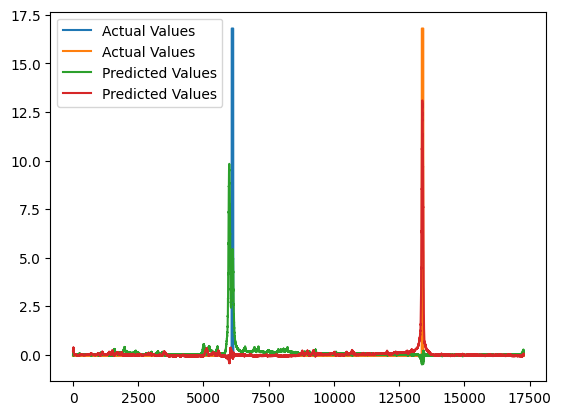

In [24]:
i = 2
# sid = val_series_all.filter(pl.col())
plt.plot(val_y_all[i], label="Actual Values")
print(val_series_all[i])

plt.plot(val_preds_all[i], label="Predicted Values")


plt.legend()
plt.show()

In [25]:
def nms_nikhil(preds_orig, k_orig=150, max_thresh=0.05, max_count=500):
    
    preds=preds_orig.copy()
    preds = np.convolve(preds, np.array([0.2, 0.6, 0.2]), mode='same')

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base
        supress_rates[:20] = 0
        # supress_rates[20:] += 0.1

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]

        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)




def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [26]:
%%time
scores = []

for fold_num in range(1, 5+1):
    
    test_ser_ids = list(np.unique(val_series_lst[fold_num-1]))


    val_events_df = train_events.filter(pl.col('series_id').is_in(test_ser_ids))
    score = post_process_preds(val_events_df,
                               val_preds_lst[fold_num-1],
                               val_series_lst[fold_num-1],
                               val_starts_splits_lst[fold_num-1],
                               cfg.samp_freq,
                               get_score=True)
    print(score)
    scores.append(score)
    
np.mean(scores), np.std(scores)

0.8022631312494917
0.8294395003530312
0.816764528932012
0.8176620669745143
0.8230182746728448
CPU times: user 30 s, sys: 39.6 s, total: 1min 9s
Wall time: 1min 8s


(0.8178295004363788, 0.009002105576734986)

In [27]:
val_preds_df = post_process_preds(val_events_df, val_preds_all, val_series_all, val_starts_splits_all, cfg.samp_freq, get_score=False)

In [28]:
def round_to_nearest_multiple(df, column_name='step'):
    df[column_name] = df[column_name].apply(lambda x: x+1 if x%12==0  else x)
    return df


In [29]:
val_preds_df = round_to_nearest_multiple(val_preds_df.to_pandas())
val_preds_df = pl.DataFrame(val_preds_df)

In [30]:
tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

In [33]:
train_events

series_id,night,event,step,timestamp,date
str,i64,str,i64,datetime[μs],date
"""038441c925bb""",1,"""onset""",4992,2018-08-14 22:26:00,2018-08-14
"""038441c925bb""",1,"""wakeup""",10932,2018-08-15 06:41:00,2018-08-15
"""038441c925bb""",2,"""onset""",20244,2018-08-15 19:37:00,2018-08-15
"""038441c925bb""",2,"""wakeup""",27492,2018-08-16 05:41:00,2018-08-16
"""038441c925bb""",3,"""onset""",39996,2018-08-16 23:03:00,2018-08-16
"""038441c925bb""",3,"""wakeup""",44400,2018-08-17 05:10:00,2018-08-17
"""038441c925bb""",4,"""onset""",57240,2018-08-17 23:00:00,2018-08-17
"""038441c925bb""",4,"""wakeup""",62856,2018-08-18 06:48:00,2018-08-18
"""038441c925bb""",6,"""onset""",91296,2018-08-19 22:18:00,2018-08-19


In [34]:
metric_fast.comp_scorer(train_events, val_preds_df, tolerances=tolerances)

0.816398799536687

In [37]:
preds_partitions  = val_preds_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)
events_partitions  = val_events_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)

tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

scores_dict = {}
for ser_id in tqdm(events_partitions.keys()):
    scores_dict[ser_id] = metric_fast.comp_scorer(events_partitions[ser_id], preds_partitions[ser_id],
                                                  tolerances)
    

100%|██████████| 52/52 [00:11<00:00,  4.71it/s]


In [38]:
pd.Series(scores_dict).sort_values()

f56824b503a0    0.104892
854206f602d0    0.341218
703b5efa9bc1    0.476915
0a96f4993bd7    0.567911
6ca4f4fca6a2    0.620421
280e08693c6d    0.660638
cf13ed7e457a    0.725000
1762ab70ec76    0.734673
8b8b9e29171c    0.775790
72bbd1ac3edf    0.776648
ccdee561ee5d    0.791009
91cb6c98201f    0.797848
dfc3ccebfdc9    0.800082
038441c925bb    0.808368
a167532acca2    0.809247
51b23d177971    0.816383
694faf956ebf    0.821412
0402a003dae9    0.821771
6bf95a3cf91c    0.821938
b84960841a75    0.825812
3d53bfea61d6    0.838426
fe90110788d2    0.838430
d2d6b9af0553    0.844190
e0d7b0dcf9f3    0.853044
483d6545417f    0.853561
ce85771a714c    0.857657
8898e6db816d    0.868157
d150801f3145    0.870137
f88e18cb4100    0.876963
ebd76e93ec7d    0.880675
c38707ef76df    0.887521
18b61dd5aae8    0.888008
062cae666e2a    0.888333
a81f4472c637    0.894801
804594bb1f06    0.897186
1955d568d987    0.901855
91127c2b0e60    0.903690
ce9164297046    0.912093
72d2234e84e4    0.912264
d043c0ca71cd    0.912957


In [39]:
cfg_attributes_dict = {k: v for k, v in cfg.__dict__.items() if not k.startswith('__') and not callable(v)}
joblib.dump(cfg_attributes_dict, os.path.join(cfg.output_dir, cfg.ver, 'cfg.pkl'))
joblib.dump(model_dct, os.path.join(cfg.output_dir, cfg.ver, 'model_dct.pkl'))

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_series_all.npy'), val_series_all)


val_preds_df.to_pandas().to_csv(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_df.csv'), index=False)

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [41]:
import json

meta_json = {
  "title": f"sleep-model-{cfg.ver}",
  "id": f"nikhilmishradev/sleep-model-{cfg.ver}",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

json.dump(meta_json, open(os.path.join(cfg.output_dir, cfg.ver, 'dataset-metadata.json'), 'w'))

In [42]:
# !rm -r ../outputs/vx/*
# !cp -r {os.path.join(cfg.output_dir, cfg.ver)}/* ../outputs/vx
# !rm ../outputs/vx/val_preds_all.npy ../outputs/vx/val_y_all.npy
# !pip install -q kaggle
# !kaggle datasets create -p ../outputs/vx

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file cfg.pkl
100%|███████████████████████████████████████████| 119/119 [00:02<00:00, 58.7B/s]
Upload successful: cfg.pkl (119B)
Starting upload for file model_dct.pkl
100%|████████████████████████████████████████| 1.99k/1.99k [00:02<00:00, 889B/s]
Upload successful: model_dct.pkl (2KB)
Starting upload for file oof_preds.parquet
100%|██████████████████████████████████████| 1.02G/1.02G [00:59<00:00, 18.5MB/s]
Upload successful: oof_preds.parquet (1GB)
Starting upload for file tf_model_fold_1.h5
100%|████████████████████████████████████████| 133M/133M [00:10<00:00, 12.9MB/s]
Upload successful: tf_model_fold_1.h5 (133MB)
Starting upload for file tf_model_fold_2.h5
100%|████████████████████████████████████████| 133M/133M [00:11<00:00, 12.3MB/s]
Upload successful: tf_model_fold_2.h5 (133MB)
Starting upload for file tf_model_fold_3.h5
100%|████████████████████████████████████████| 133M/133M [00:11<00:0

In [46]:
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [47]:
cfg.ver

'fm-v13-final'

In [ ]:
s